This code creates a buffer(50 meters max) around the spill points and finds the nearest flowline intersection, asserting that the operator name is the same. It then changes the matches spills geometry location to its respective flowline intersection point. 

- you cannot export 2 geometry columns, so we only kept the flowline geometry, not the spills

## Setup

In [1]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import MultiLineString, LineString, Point
from shapely.ops import nearest_points
from multiprocessing import Pool, cpu_count
from sklearn.neighbors import BallTree

import contextily as ctx
from matplotlib.colors import ListedColormap, Normalize
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

os.chdir('/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/Data')

In [2]:
spills_gdf   = gpd.read_file("spills.geojson")
spills_gdf.shape

(1199, 15)

## Matching

In [3]:
import geopandas as gpd
import pandas as pd
from shapely.ops import nearest_points

# 1. Load your augmented crude-oil lines and your raw spills
crudeoil_gdf = gpd.read_file("split_flowlines.geojson")
spills_gdf   = gpd.read_file("spills.geojson")

# 2. Reproject both to a projected CRS for accurate meter distances (auto-UTM)
projected_crs = spills_gdf.estimate_utm_crs()  
crudeoil_gdf  = crudeoil_gdf.to_crs(projected_crs)
spills_gdf    = spills_gdf.to_crs(projected_crs)

# 3. Prepare counters and storage
matched_spills      = []
matched_spill_count = 0
missing_geom_spill  = 0
no_op_spill         = 0
no_match_spill      = 0

# 4. Loop over every spill point
for idx, spill in spills_gdf.iterrows():
    pt = spill.geometry
    if pt is None or pt.is_empty:
        print(f"[Spill {idx}] Missing geometry – skipping.")
        missing_geom_spill += 1
        continue

    op = spill.get("Operator Name", "")
    if pd.isnull(op) or not op.strip():
        print(f"[Spill {idx}] No Operator Name – skipping.")
        no_op_spill += 1
        continue

    op_name = op.strip().lower()
    candidates = crudeoil_gdf[
        crudeoil_gdf["Operator"]
            .str.strip()
            .str.lower()
            .eq(op_name)
    ].copy()
    candidates = candidates[candidates.geometry.notnull()]

    if candidates.empty:
        print(f"[Spill {idx}] No crude-oil lines for operator “{op}”.")
        no_match_spill += 1
        continue

    dists = candidates.geometry.distance(pt).dropna()
    if dists.empty:
        print(f"[Spill {idx}] All distances NaN – skipping.")
        no_match_spill += 1
        continue

    nearest_idx = dists.idxmin()
    min_dist    = dists.min()
    nearest_line = crudeoil_gdf.loc[nearest_idx]

    # exact nearest point on the line
    _, nearest_pt = nearest_points(pt, nearest_line.geometry)

    matched_spill_count += 1
    print(f"[Match {matched_spill_count}] spill {idx} → crude-oil {nearest_idx} at {min_dist:.2f} m")

    # build a new row: copy all original spill attrs but replace geometry
    new_spill = spill.copy()
    new_spill["match_point"]        = nearest_pt
    new_spill["match_distance_m"]   = min_dist
    new_spill["matched_crudeoil_idx"] = nearest_idx

    matched_spills.append(new_spill)

# 5. Summary
print("\n=== Spills Matching Complete ===")
print(f"Total spills:              {len(spills_gdf)}")
print(f"Matched spills:            {matched_spill_count}")
print(f"Missing geometry spills:   {missing_geom_spill}")
print(f"No Operator Name spills:   {no_op_spill}")
print(f"No line match spills:      {no_match_spill}")

# 6. Create GeoDataFrame of matched spills
matched_spills_gdf = gpd.GeoDataFrame(matched_spills, crs=spills_gdf.crs)

# 7. Swap in match_point as the new geometry
matched_spills_gdf = matched_spills_gdf.rename(columns={"geometry": "orig_geometry"})
matched_spills_gdf["geometry"] = matched_spills_gdf["match_point"]
matched_spills_gdf = matched_spills_gdf.set_geometry("geometry")

# 7b. **Re‐declare** the CRS so GeoPandas knows these geometries are still in your projected UTM
matched_spills_gdf = matched_spills_gdf.set_crs(projected_crs, allow_override=True)

# 8. Now reproject to WGS84 lon/lat
matched_spills_gdf = matched_spills_gdf.to_crs(epsg=4326)

# 9. (Optional) drop backup if you like
matched_spills_gdf = matched_spills_gdf.drop(columns=["orig_geometry", "match_point"])

# 10. Write out your final GeoJSON
matched_spills_gdf.to_file("updated_spills.geojson", driver="GeoJSON")

print("Wrote updated_spills.geojson in EPSG:4326.")

[Spill 0] No crude-oil lines for operator “K P KAUFFMAN COMPANY INC”.
[Match 1] spill 1 → crude-oil 17264 at 26869.64 m
[Spill 2] No crude-oil lines for operator “GRYNBERG* JACK DBA GRYNBERG PETROLEUM CO”.
[Match 2] spill 3 → crude-oil 8220 at 361.28 m
[Match 3] spill 4 → crude-oil 148076 at 578.34 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 4] spill 5 → crude-oil 34892 at 10.85 m
[Match 5] spill 6 → crude-oil 96759 at 20.11 m
[Match 6] spill 7 → crude-oil 106007 at 1042.53 m
[Match 7] spill 8 → crude-oil 149728 at 2475.89 m
[Match 8] spill 9 → crude-oil 146362 at 1473.13 m
[Match 9] spill 10 → crude-oil 1276 at 27.22 m
[Match 10] spill 11 → crude-oil 158368 at 238.35 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 11] spill 12 → crude-oil 117955 at 203.18 m
[Match 12] spill 13 → crude-oil 143879 at 33.13 m
[Match 13] spill 14 → crude-oil 41931 at 80.61 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 14] spill 15 → crude-oil 129374 at 2.74 m
[Match 15] spill 16 → crude-oil 129240 at 84.26 m
[Match 16] spill 17 → crude-oil 102515 at 6.70 m
[Match 17] spill 18 → crude-oil 146533 at 24.66 m
[Match 18] spill 19 → crude-oil 143659 at 84.38 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 19] spill 20 → crude-oil 6429 at 46.33 m
[Match 20] spill 21 → crude-oil 144160 at 47.66 m
[Match 21] spill 22 → crude-oil 57187 at 8.64 m
[Match 22] spill 23 → crude-oil 14733 at 167.48 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Spill 24] No crude-oil lines for operator “COACHMAN ENERGY OPERATING COMPANY LLC ”.
[Match 23] spill 25 → crude-oil 147655 at 16.39 m
[Match 24] spill 26 → crude-oil 144447 at 18.34 m
[Spill 27] No crude-oil lines for operator “PIONEER NATURAL RESOURCES USA INC ”.
[Spill 28] No crude-oil lines for operator “WARD & SON* ALFRED ”.
[Match 25] spill 29 → crude-oil 32802 at 698.78 m
[Match 26] spill 30 → crude-oil 10545 at 1928.56 m
[Match 27] spill 31 → crude-oil 10545 at 1928.56 m
[Spill 32] No crude-oil lines for operator “TEXACO EXPLORATION AND PRODUCTION INC ”.
[Match 28] spill 33 → crude-oil 23131 at 36.15 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 29] spill 34 → crude-oil 81904 at 471.50 m
[Spill 35] No crude-oil lines for operator “PIONEER NATURAL RESOURCES USA INC ”.
[Spill 36] No crude-oil lines for operator “ENDURING RESOURCES LLC ”.
[Match 30] spill 37 → crude-oil 149981 at 74.13 m
[Match 31] spill 38 → crude-oil 90185 at 245.88 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 32] spill 39 → crude-oil 152334 at 17.61 m
[Match 33] spill 40 → crude-oil 99024 at 105.69 m
[Match 34] spill 41 → crude-oil 3772 at 10.58 m
[Match 35] spill 42 → crude-oil 146533 at 55.48 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 36] spill 43 → crude-oil 61264 at 44.26 m
[Match 37] spill 44 → crude-oil 146792 at 4618.02 m
[Spill 45] No crude-oil lines for operator “DCP OPERATING COMPANY LP ”.
[Match 38] spill 46 → crude-oil 115280 at 9.61 m
[Match 39] spill 47 → crude-oil 162230 at 28.88 m
[Match 40] spill 48 → crude-oil 131694 at 1619.75 m
[Match 41] spill 49 → crude-oil 46889 at 0.04 m
[Match 42] spill 50 → crude-oil 46889 at 0.04 m
[Match 43] spill 51 → crude-oil 146699 at 4.51 m
[Match 44] spill 52 → crude-oil 25257 at 66.13 m
[Match 45] spill 53 → crude-oil 145515 at 68.45 m
[Match 46] spill 54 → crude-oil 145515 at 13.06 m
[Match 47] spill 55 → crude-oil 921 at 17.28 m
[Match 48] spill 56 → crude-oil 143323 at 16.37 m
[Match 49] spill 57 → crude-oil 139910 at 169.49 m
[Match 50] spill 58 → crude-oil 42076 at 2.20 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 51] spill 59 → crude-oil 79492 at 6.12 m
[Match 52] spill 60 → crude-oil 155795 at 38.91 m
[Match 53] spill 61 → crude-oil 155795 at 38.91 m
[Match 54] spill 62 → crude-oil 152252 at 0.74 m
[Match 55] spill 63 → crude-oil 2962 at 38.82 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 56] spill 64 → crude-oil 127975 at 43.57 m
[Match 57] spill 65 → crude-oil 145330 at 391.14 m
[Match 58] spill 66 → crude-oil 153631 at 0.01 m
[Match 59] spill 67 → crude-oil 30446 at 40.44 m
[Match 60] spill 68 → crude-oil 151897 at 1084.99 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 61] spill 69 → crude-oil 5569 at 4.16 m
[Match 62] spill 70 → crude-oil 40063 at 20.67 m
[Match 63] spill 71 → crude-oil 32043 at 0.51 m
[Match 64] spill 72 → crude-oil 12184 at 12.25 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 65] spill 73 → crude-oil 1326 at 4.66 m
[Match 66] spill 74 → crude-oil 36700 at 27.51 m
[Match 67] spill 75 → crude-oil 8511 at 44.08 m
[Match 68] spill 76 → crude-oil 153139 at 452.48 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 69] spill 77 → crude-oil 12847 at 24.57 m
[Match 70] spill 78 → crude-oil 27996 at 190.10 m
[Match 71] spill 79 → crude-oil 154021 at 7.54 m
[Match 72] spill 80 → crude-oil 24492 at 680.33 m
[Spill 81] No crude-oil lines for operator “PIONEER NATURAL RESOURCES USA INC ”.
[Spill 82] No crude-oil lines for operator “SG INTERESTS I LTD ”.
[Match 73] spill 83 → crude-oil 25934 at 46.93 m
[Match 74] spill 84 → crude-oil 95658 at 1.14 m
[Match 75] spill 85 → crude-oil 24329 at 2.52 m
[Match 76] spill 86 → crude-oil 100760 at 5736.46 m
[Match 77] spill 87 → crude-oil 87683 at 270.78 m
[Match 78] spill 88 → crude-oil 52997 at 436.50 m
[Match 79] spill 89 → crude-oil 5593 at 10.86 m
[Spill 90] No crude-oil lines for operator “PIONEER NATURAL RESOURCES USA INC ”.
[Match 80] spill 91 → crude-oil 21985 at 15.55 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 81] spill 92 → crude-oil 159567 at 4361.34 m
[Match 82] spill 93 → crude-oil 48945 at 2069.02 m
[Match 83] spill 94 → crude-oil 39786 at 3.86 m
[Match 84] spill 95 → crude-oil 856 at 10.73 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 85] spill 96 → crude-oil 2169 at 8.20 m
[Match 86] spill 97 → crude-oil 67213 at 4180.85 m
[Match 87] spill 98 → crude-oil 45885 at 411.23 m
[Match 88] spill 99 → crude-oil 110673 at 97.93 m
[Match 89] spill 100 → crude-oil 10457 at 3509.64 m
[Match 90] spill 101 → crude-oil 144035 at 3434.00 m
[Match 91] spill 102 → crude-oil 3495 at 23.28 m
[Match 92] spill 103 → crude-oil 3038 at 3.66 m
[Match 93] spill 104 → crude-oil 41719 at 370.32 m
[Match 94] spill 105 → crude-oil 144502 at 5.11 m
[Match 95] spill 106 → crude-oil 31331 at 9.47 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 96] spill 107 → crude-oil 41907 at 36.17 m
[Match 97] spill 108 → crude-oil 146408 at 5.45 m
[Match 98] spill 109 → crude-oil 156486 at 158.31 m
[Match 99] spill 110 → crude-oil 14681 at 12.11 m
[Match 100] spill 111 → crude-oil 6611 at 6.64 m
[Match 101] spill 112 → crude-oil 12746 at 288.08 m
[Match 102] spill 113 → crude-oil 25550 at 3.35 m
[Match 103] spill 114 → crude-oil 102036 at 12.94 m
[Match 104] spill 115 → crude-oil 145961 at 36.83 m
[Match 105] spill 116 → crude-oil 106856 at 83.16 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 106] spill 117 → crude-oil 13160 at 3.94 m
[Match 107] spill 118 → crude-oil 56043 at 0.98 m
[Match 108] spill 119 → crude-oil 67213 at 3857.39 m
[Match 109] spill 120 → crude-oil 49567 at 8693.97 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 110] spill 121 → crude-oil 142847 at 24.40 m
[Match 111] spill 122 → crude-oil 3655 at 20.57 m
[Match 112] spill 123 → crude-oil 8492 at 4.88 m
[Match 113] spill 124 → crude-oil 3655 at 88.67 m
[Spill 125] No crude-oil lines for operator “ARP PRODUCTION COMPANY LLC”.
[Match 114] spill 126 → crude-oil 72079 at 171.53 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 115] spill 127 → crude-oil 33234 at 3.65 m
[Spill 128] No crude-oil lines for operator “PIONEER NATURAL RESOURCES USA INC”.
[Spill 129] No crude-oil lines for operator “CUB CREEK ENERGY”.
[Match 116] spill 130 → crude-oil 40925 at 1.50 m
[Match 117] spill 131 → crude-oil 156764 at 859.68 m
[Match 118] spill 132 → crude-oil 28643 at 5.88 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 119] spill 133 → crude-oil 15290 at 7.02 m
[Match 120] spill 134 → crude-oil 3721 at 243.40 m
[Match 121] spill 135 → crude-oil 77100 at 0.17 m
[Match 122] spill 136 → crude-oil 25339 at 22.89 m
[Spill 137] No crude-oil lines for operator “PIONEER NATURAL RESOURCES USA INC”.


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 123] spill 138 → crude-oil 13916 at 1.73 m
[Match 124] spill 139 → crude-oil 145594 at 11.28 m
[Match 125] spill 140 → crude-oil 12404 at 12.07 m
[Match 126] spill 141 → crude-oil 5034 at 11.23 m
[Match 127] spill 142 → crude-oil 4771 at 39.56 m
[Match 128] spill 143 → crude-oil 20365 at 8.98 m
[Match 129] spill 144 → crude-oil 1307 at 14.25 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 130] spill 145 → crude-oil 12650 at 14413.88 m
[Match 131] spill 146 → crude-oil 101023 at 21.37 m
[Match 132] spill 147 → crude-oil 100280 at 83.53 m
[Match 133] spill 148 → crude-oil 6709 at 40.64 m
[Match 134] spill 149 → crude-oil 41449 at 7673.86 m
[Match 135] spill 150 → crude-oil 33419 at 6937.27 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 136] spill 151 → crude-oil 3292 at 34.65 m
[Match 137] spill 152 → crude-oil 156740 at 24.53 m
[Match 138] spill 153 → crude-oil 10574 at 1.47 m
[Match 139] spill 154 → crude-oil 158071 at 74.22 m
[Match 140] spill 155 → crude-oil 21011 at 88.22 m
[Match 141] spill 156 → crude-oil 9836 at 29.41 m
[Match 142] spill 157 → crude-oil 73033 at 3.61 m
[Spill 158] No crude-oil lines for operator “ANDEAVOR FIELD SERVICES LLC”.
[Match 143] spill 159 → crude-oil 39576 at 6.89 m
[Match 144] spill 160 → crude-oil 43763 at 18.77 m
[Match 145] spill 161 → crude-oil 127847 at 1400.94 m
[Match 146] spill 162 → crude-oil 70431 at 1611.09 m
[Spill 163] No crude-oil lines for operator “ANDEAVOR FIELD SERVICES LLC”.


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Spill 164] No crude-oil lines for operator “PIONEER NATURAL RESOURCES USA INC”.
[Match 147] spill 165 → crude-oil 30385 at 7.76 m
[Spill 166] No crude-oil lines for operator “ROCKY MTN NATURAL GAS LLC ADBA BLACK HILLS ENERGY”.
[Match 148] spill 167 → crude-oil 15731 at 55.16 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 149] spill 168 → crude-oil 34146 at 7.86 m
[Match 150] spill 169 → crude-oil 36988 at 2556.43 m
[Match 151] spill 170 → crude-oil 132004 at 58.26 m
[Match 152] spill 171 → crude-oil 21303 at 23.06 m
[Match 153] spill 172 → crude-oil 82870 at 13.37 m
[Match 154] spill 173 → crude-oil 64661 at 26.08 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 155] spill 174 → crude-oil 160069 at 187.21 m
[Match 156] spill 175 → crude-oil 66163 at 1.85 m
[Match 157] spill 176 → crude-oil 3625 at 76.98 m
[Match 158] spill 177 → crude-oil 147634 at 54.47 m
[Match 159] spill 178 → crude-oil 17493 at 1.17 m
[Match 160] spill 179 → crude-oil 35907 at 2.66 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 161] spill 180 → crude-oil 10850 at 1.78 m
[Spill 181] No crude-oil lines for operator “GUNNISON ENERGY LLC”.
[Match 162] spill 182 → crude-oil 1453 at 5.70 m
[Match 163] spill 183 → crude-oil 43763 at 13.36 m
[Match 164] spill 184 → crude-oil 42339 at 56.44 m
[Match 165] spill 185 → crude-oil 16401 at 103.99 m
[Match 166] spill 186 → crude-oil 55158 at 2964.75 m
[Match 167] spill 187 → crude-oil 100760 at 985.17 m
[Spill 188] No crude-oil lines for operator “WAPITI OPERATING LLC”.
[Match 168] spill 189 → crude-oil 90185 at 230.30 m
[Match 169] spill 190 → crude-oil 155879 at 229.67 m
[Match 170] spill 191 → crude-oil 16395 at 3.65 m
[Match 171] spill 192 → crude-oil 157144 at 7.04 m
[Spill 193] No crude-oil lines for operator “EOG RESOURCES INC”.
[Match 172] spill 194 → crude-oil 44 at 41.67 m
[Match 173] spill 195 → crude-oil 101023 at 23.70 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 174] spill 196 → crude-oil 3625 at 121.13 m
[Match 175] spill 197 → crude-oil 155273 at 108.21 m
[Match 176] spill 198 → crude-oil 155273 at 25.30 m
[Match 177] spill 199 → crude-oil 38726 at 14.63 m
[Match 178] spill 200 → crude-oil 160227 at 489.68 m
[Spill 201] No crude-oil lines for operator “EVERGREEN NATURAL RESOURCES LLC”.


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 179] spill 202 → crude-oil 647 at 0.31 m
[Match 180] spill 203 → crude-oil 148035 at 13.33 m
[Match 181] spill 204 → crude-oil 119346 at 379.24 m
[Match 182] spill 205 → crude-oil 14288 at 15786.91 m
[Match 183] spill 206 → crude-oil 49567 at 8645.61 m
[Match 184] spill 207 → crude-oil 155273 at 25.30 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 185] spill 208 → crude-oil 43763 at 16.40 m
[Match 186] spill 209 → crude-oil 143661 at 1.84 m
[Match 187] spill 210 → crude-oil 28755 at 196.79 m
[Match 188] spill 211 → crude-oil 39158 at 7.27 m
[Match 189] spill 212 → crude-oil 5024 at 103.94 m
[Match 190] spill 213 → crude-oil 22569 at 1.13 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 191] spill 214 → crude-oil 143930 at 93.84 m
[Spill 215] No crude-oil lines for operator “EVERGREEN NATURAL RESOURCES LLC”.
[Spill 216] No crude-oil lines for operator “ROCKY MOUNTAIN MIDSTREAM LLC”.
[Match 192] spill 217 → crude-oil 17434 at 32.46 m
[Match 193] spill 218 → crude-oil 24239 at 61.18 m
[Match 194] spill 219 → crude-oil 161439 at 1050.15 m
[Match 195] spill 220 → crude-oil 61608 at 48.14 m
[Match 196] spill 221 → crude-oil 121057 at 883.20 m
[Match 197] spill 222 → crude-oil 155752 at 53.49 m
[Spill 223] No crude-oil lines for operator “GRAYHORSE OPERATING INC”.
[Match 198] spill 224 → crude-oil 5182 at 1.24 m
[Match 199] spill 225 → crude-oil 143866 at 9.04 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Spill 226] No crude-oil lines for operator “ROCKY MOUNTAIN MIDSTREAM LLC”.
[Match 200] spill 227 → crude-oil 3165 at 19.97 m
[Match 201] spill 228 → crude-oil 34331 at 2.13 m
[Match 202] spill 229 → crude-oil 49567 at 1758.63 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 203] spill 230 → crude-oil 15097 at 4.20 m
[Match 204] spill 231 → crude-oil 145543 at 38.26 m
[Match 205] spill 232 → crude-oil 99288 at 1.80 m
[Match 206] spill 233 → crude-oil 143959 at 65.48 m
[Match 207] spill 234 → crude-oil 59940 at 7.33 m
[Match 208] spill 235 → crude-oil 146849 at 1358.60 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 209] spill 236 → crude-oil 3618 at 7.34 m
[Spill 237] No crude-oil lines for operator “NICKEL ROAD OPERATING LLC”.
[Match 210] spill 238 → crude-oil 148184 at 22.93 m
[Match 211] spill 239 → crude-oil 103318 at 3.00 m
[Spill 240] No crude-oil lines for operator “GUNNISON ENERGY LLC”.
[Match 212] spill 241 → crude-oil 63153 at 20745.52 m
[Match 213] spill 242 → crude-oil 126968 at 4.94 m
[Match 214] spill 243 → crude-oil 15097 at 48.15 m
[Match 215] spill 244 → crude-oil 144289 at 0.03 m
[Match 216] spill 245 → crude-oil 162825 at 3.43 m
[Match 217] spill 246 → crude-oil 15265 at 42.03 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 218] spill 247 → crude-oil 140736 at 9.59 m
[Spill 248] No crude-oil lines for operator “SG INTERESTS I LTD”.
[Spill 249] No crude-oil lines for operator “MUSTANG RESOURCES LLC”.
[Match 219] spill 250 → crude-oil 12650 at 4520.30 m
[Match 220] spill 251 → crude-oil 49567 at 8680.72 m
[Match 221] spill 252 → crude-oil 118371 at 13.57 m
[Match 222] spill 253 → crude-oil 142977 at 1.82 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 223] spill 254 → crude-oil 17912 at 26.14 m
[Match 224] spill 255 → crude-oil 156483 at 15.45 m
[Match 225] spill 256 → crude-oil 17855 at 65.64 m
[Match 226] spill 257 → crude-oil 119866 at 78.14 m
[Match 227] spill 258 → crude-oil 32122 at 5.87 m
[Match 228] spill 259 → crude-oil 143903 at 162.02 m
[Match 229] spill 260 → crude-oil 122895 at 10.07 m
[Match 230] spill 261 → crude-oil 147313 at 66.49 m
[Match 231] spill 262 → crude-oil 63858 at 2.82 m
[Match 232] spill 263 → crude-oil 61608 at 84.28 m
[Spill 264] No crude-oil lines for operator “HUNTER RIDGE ENERGY SERVICES LLC”.
[Match 233] spill 265 → crude-oil 157553 at 1140.66 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 234] spill 266 → crude-oil 206 at 98.59 m
[Spill 267] No crude-oil lines for operator “EVERGREEN NATURAL RESOURCES LLC”.
[Match 235] spill 268 → crude-oil 153494 at 3.00 m
[Match 236] spill 269 → crude-oil 31040 at 935.05 m
[Match 237] spill 270 → crude-oil 84041 at 23.08 m
[Match 238] spill 271 → crude-oil 75322 at 68.61 m
[Match 239] spill 272 → crude-oil 147313 at 76.95 m
[Match 240] spill 273 → crude-oil 31923 at 33.63 m
[Match 241] spill 274 → crude-oil 157901 at 15.60 m
[Match 242] spill 275 → crude-oil 90384 at 33.08 m
[Match 243] spill 276 → crude-oil 36692 at 529.61 m
[Match 244] spill 277 → crude-oil 145133 at 11.48 m
[Match 245] spill 278 → crude-oil 45446 at 84.61 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 246] spill 279 → crude-oil 147948 at 44.42 m
[Match 247] spill 280 → crude-oil 56597 at 2.22 m
[Match 248] spill 281 → crude-oil 75494 at 247.14 m
[Match 249] spill 282 → crude-oil 78253 at 24.73 m
[Spill 283] No crude-oil lines for operator “EVERGREEN NATURAL RESOURCES LLC”.
[Match 250] spill 284 → crude-oil 102515 at 42.22 m
[Match 251] spill 285 → crude-oil 150615 at 12.10 m
[Spill 286] No crude-oil lines for operator “EVERGREEN NATURAL RESOURCES LLC”.
[Spill 287] No crude-oil lines for operator “EVERGREEN NATURAL RESOURCES LLC”.
[Spill 288] No crude-oil lines for operator “EVERGREEN NATURAL RESOURCES LLC”.
[Match 252] spill 289 → crude-oil 147903 at 149.96 m
[Match 253] spill 290 → crude-oil 145691 at 88.64 m
[Spill 291] No crude-oil lines for operator “EVERGREEN NATURAL RESOURCES LLC”.
[Match 254] spill 292 → crude-oil 144062 at 66.22 m
[Match 255] spill 293 → crude-oil 149826 at 9.30 m
[Match 256] spill 294 → crude-oil 18423 at 5147.45 m
[Match 257] spill 295 → crude-oil 1

/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 259] spill 297 → crude-oil 12356 at 12.43 m
[Match 260] spill 298 → crude-oil 76341 at 0.03 m
[Match 261] spill 299 → crude-oil 128884 at 13.73 m
[Match 262] spill 300 → crude-oil 102515 at 42.22 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 263] spill 301 → crude-oil 18715 at 8.81 m
[Match 264] spill 302 → crude-oil 149463 at 249.86 m
[Match 265] spill 303 → crude-oil 107771 at 3.85 m
[Match 266] spill 304 → crude-oil 144936 at 71.23 m
[Match 267] spill 305 → crude-oil 59927 at 18.67 m
[Match 268] spill 306 → crude-oil 22048 at 75.78 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 269] spill 307 → crude-oil 26385 at 5.33 m
[Match 270] spill 308 → crude-oil 160659 at 3.07 m
[Match 271] spill 309 → crude-oil 135922 at 89.92 m
[Match 272] spill 310 → crude-oil 278 at 2.61 m
[Spill 311] No crude-oil lines for operator “NICKEL ROAD OPERATING LLC”.
[Match 273] spill 312 → crude-oil 80036 at 13.82 m
[Match 274] spill 313 → crude-oil 38252 at 5.40 m
[Match 275] spill 314 → crude-oil 10545 at 4751.06 m
[Match 276] spill 315 → crude-oil 75575 at 393.94 m
[Match 277] spill 316 → crude-oil 7242 at 31.25 m
[Spill 317] No crude-oil lines for operator “BNN WESTERN LLC”.


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 278] spill 318 → crude-oil 159534 at 2.34 m
[Match 279] spill 319 → crude-oil 59927 at 17.17 m
[Match 280] spill 320 → crude-oil 88445 at 2.81 m
[Match 281] spill 321 → crude-oil 146461 at 2324.83 m
[Match 282] spill 322 → crude-oil 13753 at 51.44 m
[Match 283] spill 323 → crude-oil 4047 at 0.90 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 284] spill 324 → crude-oil 33624 at 6.78 m
[Match 285] spill 325 → crude-oil 69938 at 5.33 m
[Match 286] spill 326 → crude-oil 11829 at 3.94 m
[Match 287] spill 327 → crude-oil 15875 at 27.53 m
[Spill 328] No crude-oil lines for operator “EVERGREEN NATURAL RESOURCES LLC”.
[Match 288] spill 329 → crude-oil 42324 at 0.27 m
[Spill 330] No crude-oil lines for operator “EVERGREEN NATURAL RESOURCES LLC”.
[Match 289] spill 331 → crude-oil 63898 at 1334.88 m
[Spill 332] No crude-oil lines for operator “EVERGREEN NATURAL RESOURCES LLC”.
[Match 290] spill 333 → crude-oil 18952 at 34.54 m
[Match 291] spill 334 → crude-oil 921 at 29.14 m
[Spill 335] No crude-oil lines for operator “EVERGREEN NATURAL RESOURCES LLC”.
[Match 292] spill 336 → crude-oil 78218 at 204.00 m
[Spill 337] No crude-oil lines for operator “DCP OPERATING COMPANY LP”.
[Match 293] spill 338 → crude-oil 3655 at 164.96 m
[Spill 339] No crude-oil lines for operator “BERRY PETROLEUM COMPANY LLC”.
[Match 294] spill 340 → crude-

/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 301] spill 348 → crude-oil 48379 at 1.04 m
[Match 302] spill 349 → crude-oil 18423 at 566.54 m
[Match 303] spill 350 → crude-oil 33419 at 4102.22 m
[Spill 351] No crude-oil lines for operator “SG INTERESTS I LTD”.
[Match 304] spill 352 → crude-oil 102548 at 1.02 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 305] spill 353 → crude-oil 21323 at 2.89 m
[Match 306] spill 354 → crude-oil 161047 at 395.59 m
[Match 307] spill 355 → crude-oil 135333 at 86.28 m
[Spill 356] No crude-oil lines for operator “KTM OPERATING LLC”.
[Match 308] spill 357 → crude-oil 153089 at 0.94 m
[Match 309] spill 358 → crude-oil 36893 at 11.69 m
[Match 310] spill 359 → crude-oil 5569 at 31.64 m
[Match 311] spill 360 → crude-oil 143250 at 1123.08 m
[Match 312] spill 361 → crude-oil 5813 at 15.87 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Spill 362] No crude-oil lines for operator “BLUE CHIP OIL INC”.
[Match 313] spill 363 → crude-oil 14234 at 25.35 m
[Match 314] spill 364 → crude-oil 21315 at 1.75 m
[Match 315] spill 365 → crude-oil 18423 at 1124.85 m
[Match 316] spill 366 → crude-oil 147441 at 2.14 m
[Spill 367] No crude-oil lines for operator “NOBLE MIDSTREAM SERVICES LLC”.
[Match 317] spill 368 → crude-oil 152897 at 43.71 m
[Match 318] spill 369 → crude-oil 156731 at 4.54 m
[Match 319] spill 370 → crude-oil 57163 at 0.56 m
[Match 320] spill 371 → crude-oil 112659 at 16.07 m
[Match 321] spill 372 → crude-oil 53663 at 38.45 m
[Match 322] spill 373 → crude-oil 146654 at 26.84 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 323] spill 374 → crude-oil 159291 at 71.73 m
[Match 324] spill 375 → crude-oil 36126 at 174.00 m
[Match 325] spill 376 → crude-oil 17151 at 36.23 m
[Match 326] spill 377 → crude-oil 48284 at 6.84 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 327] spill 378 → crude-oil 162147 at 2.47 m
[Match 328] spill 379 → crude-oil 135922 at 114.96 m
[Match 329] spill 380 → crude-oil 81778 at 98.49 m
[Match 330] spill 381 → crude-oil 10817 at 1.42 m
[Match 331] spill 382 → crude-oil 15260 at 61.44 m
[Match 332] spill 383 → crude-oil 1440 at 5.84 m
[Match 333] spill 384 → crude-oil 18808 at 336.44 m
[Match 334] spill 385 → crude-oil 142817 at 1927.62 m
[Match 335] spill 386 → crude-oil 34840 at 29.54 m
[Match 336] spill 387 → crude-oil 99288 at 1.90 m
[Match 337] spill 388 → crude-oil 99288 at 1.90 m
[Match 338] spill 389 → crude-oil 148237 at 1.23 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 339] spill 390 → crude-oil 155800 at 6.71 m
[Match 340] spill 391 → crude-oil 34441 at 10.28 m
[Match 341] spill 392 → crude-oil 143702 at 55.28 m
[Spill 393] No crude-oil lines for operator “EVERGREEN NATURAL RESOURCES LLC”.
[Spill 394] No crude-oil lines for operator “DCP OPERATING COMPANY LP”.
[Match 342] spill 395 → crude-oil 27729 at 35.68 m
[Match 343] spill 396 → crude-oil 59927 at 56.01 m
[Match 344] spill 397 → crude-oil 4336 at 2.71 m
[Match 345] spill 398 → crude-oil 31488 at 18.59 m
[Match 346] spill 399 → crude-oil 30385 at 30.24 m
[Spill 400] No crude-oil lines for operator “NOBLE MIDSTREAM SERVICES LLC”.
[Match 347] spill 401 → crude-oil 146721 at 4.16 m
[Match 348] spill 402 → crude-oil 28001 at 16.99 m
[Match 349] spill 403 → crude-oil 104568 at 84.60 m
[Match 350] spill 404 → crude-oil 2707 at 2.51 m
[Match 351] spill 405 → crude-oil 921 at 17.28 m
[Match 352] spill 406 → crude-oil 142817 at 673.72 m
[Match 353] spill 407 → crude-oil 77527 at 16.72 m
[Match 354

/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 360] spill 414 → crude-oil 130771 at 42.62 m
[Match 361] spill 415 → crude-oil 97027 at 16.75 m
[Match 362] spill 416 → crude-oil 142817 at 699.03 m
[Match 363] spill 417 → crude-oil 142817 at 904.11 m
[Match 364] spill 418 → crude-oil 142785 at 1550.39 m
[Match 365] spill 419 → crude-oil 153265 at 4025.16 m
[Spill 420] No crude-oil lines for operator “EVERGREEN NATURAL RESOURCES LLC”.
[Match 366] spill 421 → crude-oil 22123 at 26.15 m
[Match 367] spill 422 → crude-oil 12630 at 14.86 m
[Match 368] spill 423 → crude-oil 55117 at 137.37 m
[Match 369] spill 424 → crude-oil 63472 at 4.31 m
[Match 370] spill 425 → crude-oil 57760 at 18.89 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 371] spill 426 → crude-oil 13648 at 81.30 m
[Match 372] spill 427 → crude-oil 142921 at 1.83 m
[Match 373] spill 428 → crude-oil 5250 at 123.41 m
[Match 374] spill 429 → crude-oil 162008 at 21.98 m
[Match 375] spill 430 → crude-oil 5624 at 14.19 m
[Match 376] spill 431 → crude-oil 921 at 21.65 m
[Match 377] spill 432 → crude-oil 66335 at 62.94 m
[Match 378] spill 433 → crude-oil 150751 at 8.57 m
[Match 379] spill 434 → crude-oil 145969 at 22.60 m
[Spill 435] No crude-oil lines for operator “WARD & SON* ALFRED”.
[Match 380] spill 436 → crude-oil 144042 at 1.89 m
[Match 381] spill 437 → crude-oil 86531 at 49.03 m
[Match 382] spill 438 → crude-oil 137121 at 4.36 m
[Match 383] spill 439 → crude-oil 7286 at 2.42 m
[Match 384] spill 440 → crude-oil 122895 at 23.61 m
[Match 385] spill 441 → crude-oil 145370 at 1380.40 m
[Match 386] spill 442 → crude-oil 54279 at 373.87 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 387] spill 443 → crude-oil 75670 at 11.00 m
[Match 388] spill 444 → crude-oil 31788 at 57.11 m
[Match 389] spill 445 → crude-oil 154273 at 3.38 m
[Match 390] spill 446 → crude-oil 143336 at 2.21 m
[Match 391] spill 447 → crude-oil 142702 at 591.94 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 392] spill 448 → crude-oil 97243 at 22.67 m
[Match 393] spill 449 → crude-oil 146533 at 17.84 m
[Spill 450] No crude-oil lines for operator “NOBLE MIDSTREAM SERVICES LLC”.
[Match 394] spill 451 → crude-oil 141306 at 2427.98 m
[Spill 452] No crude-oil lines for operator “EVERGREEN NATURAL RESOURCES LLC”.
[Spill 453] No crude-oil lines for operator “WARD & SON* ALFRED”.
[Match 395] spill 454 → crude-oil 1818 at 144.38 m
[Match 396] spill 455 → crude-oil 102518 at 2764.12 m
[Match 397] spill 456 → crude-oil 61679 at 34.47 m
[Spill 457] No crude-oil lines for operator “SIMCOE LLC”.
[Match 398] spill 458 → crude-oil 145020 at 516.07 m
[Match 399] spill 459 → crude-oil 12970 at 258.00 m
[Spill 460] Missing geometry – skipping.
[Spill 461] Missing geometry – skipping.
[Spill 462] Missing geometry – skipping.
[Spill 463] Missing geometry – skipping.
[Spill 464] Missing geometry – skipping.
[Spill 465] Missing geometry – skipping.
[Spill 466] Missing geometry – skipping.
[Spill 467] Miss

/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 400] spill 640 → crude-oil 39244 at 41.56 m
[Match 401] spill 641 → crude-oil 25940 at 160.61 m
[Spill 642] No crude-oil lines for operator “EVERGREEN NATURAL RESOURCES LLC”.
[Match 402] spill 643 → crude-oil 137297 at 0.95 m
[Match 403] spill 644 → crude-oil 95071 at 6.75 m
[Match 404] spill 645 → crude-oil 135872 at 3574.30 m
[Spill 646] No crude-oil lines for operator “ARKOMA OPERATIONS LLC”.
[Spill 647] No crude-oil lines for operator “EVERGREEN NATURAL RESOURCES LLC”.
[Match 405] spill 648 → crude-oil 30468 at 3.41 m
[Match 406] spill 649 → crude-oil 50597 at 1.09 m
[Spill 650] No crude-oil lines for operator “SIMCOE LLC”.
[Match 407] spill 651 → crude-oil 144006 at 1593.26 m
[Match 408] spill 652 → crude-oil 27030 at 3.76 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 409] spill 653 → crude-oil 91212 at 31.97 m
[Match 410] spill 654 → crude-oil 91382 at 500.89 m
[Match 411] spill 655 → crude-oil 60107 at 1.94 m
[Match 412] spill 656 → crude-oil 145689 at 57.53 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 413] spill 657 → crude-oil 143445 at 58.52 m
[Match 414] spill 658 → crude-oil 90185 at 3.82 m
[Spill 659] No crude-oil lines for operator “TAPROOT ROCKIES MIDSTREAM LLC”.
[Match 415] spill 660 → crude-oil 143250 at 162.04 m
[Match 416] spill 661 → crude-oil 15950 at 1136.75 m
[Match 417] spill 662 → crude-oil 63153 at 9779.20 m
[Match 418] spill 663 → crude-oil 33383 at 83.81 m
[Match 419] spill 664 → crude-oil 44463 at 1.83 m
[Match 420] spill 665 → crude-oil 29891 at 2.36 m
[Match 421] spill 666 → crude-oil 7112 at 22.90 m
[Spill 667] No crude-oil lines for operator “EVERGREEN NATURAL RESOURCES LLC”.
[Match 422] spill 668 → crude-oil 149081 at 800.22 m
[Match 423] spill 669 → crude-oil 146154 at 4.73 m
[Match 424] spill 670 → crude-oil 153056 at 1.41 m
[Match 425] spill 671 → crude-oil 15995 at 0.25 m
[Match 426] spill 672 → crude-oil 147012 at 1307.69 m
[Spill 673] No crude-oil lines for operator “SIMCOE LLC”.
[Match 427] spill 674 → crude-oil 107867 at 30.98 m
[Match 428] s

/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 433] spill 681 → crude-oil 146461 at 1994.27 m
[Match 434] spill 682 → crude-oil 139504 at 102.37 m
[Match 435] spill 683 → crude-oil 921 at 12.66 m
[Match 436] spill 684 → crude-oil 78218 at 201.16 m
[Match 437] spill 685 → crude-oil 161439 at 1391.26 m
[Match 438] spill 686 → crude-oil 143640 at 17.95 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 439] spill 687 → crude-oil 123247 at 2821.45 m
[Spill 688] No crude-oil lines for operator “FUNDARE RESOURCES OPERATING COMPANY LLC”.
[Match 440] spill 689 → crude-oil 39745 at 5.45 m
[Match 441] spill 690 → crude-oil 79290 at 7.65 m
[Match 442] spill 691 → crude-oil 28001 at 17.01 m
[Spill 692] No crude-oil lines for operator “SIMCOE LLC”.
[Match 443] spill 693 → crude-oil 9647 at 10.71 m
[Match 444] spill 694 → crude-oil 148976 at 2.28 m
[Match 445] spill 695 → crude-oil 143451 at 107.00 m
[Match 446] spill 696 → crude-oil 143235 at 48.71 m
[Match 447] spill 697 → crude-oil 23734 at 351.63 m
[Match 448] spill 698 → crude-oil 110528 at 0.01 m
[Match 449] spill 699 → crude-oil 25586 at 30.16 m
[Match 450] spill 700 → crude-oil 93872 at 98.43 m
[Match 451] spill 701 → crude-oil 147847 at 20.11 m
[Match 452] spill 702 → crude-oil 107324 at 29.37 m
[Match 453] spill 703 → crude-oil 125917 at 68.30 m
[Match 454] spill 704 → crude-oil 82008 at 60.32 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 455] spill 705 → crude-oil 4414 at 382.17 m
[Match 456] spill 706 → crude-oil 108339 at 23.88 m
[Match 457] spill 707 → crude-oil 50271 at 177.31 m
[Spill 708] No crude-oil lines for operator “EVERGREEN NATURAL RESOURCES LLC”.


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 458] spill 709 → crude-oil 2254 at 28.24 m
[Match 459] spill 710 → crude-oil 158443 at 122.05 m
[Spill 711] No crude-oil lines for operator “SIMCOE LLC”.
[Match 460] spill 712 → crude-oil 46960 at 22.11 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 461] spill 713 → crude-oil 108193 at 39.42 m
[Match 462] spill 714 → crude-oil 144266 at 1.19 m
[Match 463] spill 715 → crude-oil 144501 at 7.11 m
[Spill 716] No crude-oil lines for operator “PETRO MEX RESOURCES”.
[Match 464] spill 717 → crude-oil 44 at 39.35 m
[Match 465] spill 718 → crude-oil 11765 at 3.26 m
[Match 466] spill 719 → crude-oil 14317 at 29.13 m
[Match 467] spill 720 → crude-oil 52883 at 639.19 m
[Spill 721] No crude-oil lines for operator “MONUMENT GLOBAL RESOURCES INC”.
[Match 468] spill 722 → crude-oil 103809 at 8.33 m
[Match 469] spill 723 → crude-oil 145371 at 1.34 m
[Match 470] spill 724 → crude-oil 17388 at 50.54 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 471] spill 725 → crude-oil 60301 at 1202.00 m
[Match 472] spill 726 → crude-oil 142817 at 1884.35 m
[Match 473] spill 727 → crude-oil 3629 at 95.95 m
[Match 474] spill 728 → crude-oil 11773 at 2748.77 m
[Match 475] spill 729 → crude-oil 78218 at 239.15 m
[Match 476] spill 730 → crude-oil 162825 at 43.01 m
[Match 477] spill 731 → crude-oil 19224 at 4.55 m
[Match 478] spill 732 → crude-oil 93173 at 4.80 m
[Match 479] spill 733 → crude-oil 31492 at 179.41 m
[Match 480] spill 734 → crude-oil 5250 at 124.74 m
[Spill 735] No crude-oil lines for operator “EVERGREEN NATURAL RESOURCES LLC”.
[Spill 736] No crude-oil lines for operator “EVERGREEN NATURAL RESOURCES LLC”.
[Match 481] spill 737 → crude-oil 147106 at 4885.17 m
[Match 482] spill 738 → crude-oil 51627 at 92.06 m
[Match 483] spill 739 → crude-oil 54585 at 3.43 m
[Match 484] spill 740 → crude-oil 143724 at 102.65 m
[Match 485] spill 741 → crude-oil 146594 at 0.47 m
[Match 486] spill 742 → crude-oil 10508 at 9.85 m
[Match 487] spil

/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 507] spill 768 → crude-oil 113671 at 4385.35 m
[Match 508] spill 769 → crude-oil 72549 at 1677.70 m
[Match 509] spill 770 → crude-oil 142896 at 4.99 m
[Match 510] spill 771 → crude-oil 1417 at 35.00 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 511] spill 772 → crude-oil 70136 at 4.67 m
[Spill 773] No crude-oil lines for operator “CUB CREEK ENERGY”.
[Match 512] spill 774 → crude-oil 5845 at 0.61 m
[Match 513] spill 775 → crude-oil 128809 at 41.85 m
[Match 514] spill 776 → crude-oil 3010 at 35.29 m
[Match 515] spill 777 → crude-oil 111756 at 1759.80 m
[Match 516] spill 778 → crude-oil 68214 at 189.38 m
[Match 517] spill 779 → crude-oil 145689 at 57.32 m
[Match 518] spill 780 → crude-oil 17910 at 39.49 m
[Match 519] spill 781 → crude-oil 84345 at 11.17 m
[Match 520] spill 782 → crude-oil 9536 at 1.58 m
[Match 521] spill 783 → crude-oil 143500 at 304.82 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 522] spill 784 → crude-oil 63758 at 193.66 m
[Spill 785] No crude-oil lines for operator “SIMCOE LLC”.
[Match 523] spill 786 → crude-oil 56340 at 20.78 m
[Spill 787] No crude-oil lines for operator “TAPROOT ROCKIES MIDSTREAM LLC”.
[Match 524] spill 788 → crude-oil 28946 at 12.77 m
[Match 525] spill 789 → crude-oil 143903 at 307.31 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 526] spill 790 → crude-oil 151082 at 6.14 m
[Spill 791] No crude-oil lines for operator “TALLGRASS WATER WESTERN LLC”.
[Match 527] spill 792 → crude-oil 4726 at 28.64 m
[Match 528] spill 793 → crude-oil 149623 at 35.01 m
[Match 529] spill 794 → crude-oil 135872 at 14.05 m
[Match 530] spill 795 → crude-oil 106578 at 74.98 m
[Spill 796] No crude-oil lines for operator “SUMMIT MIDSTREAM PARTNERS LLC”.
[Match 531] spill 797 → crude-oil 2512 at 23.41 m
[Spill 798] No crude-oil lines for operator “SIMCOE LLC”.


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 532] spill 799 → crude-oil 28001 at 15.31 m
[Match 533] spill 800 → crude-oil 30668 at 1667.78 m
[Match 534] spill 801 → crude-oil 145257 at 147.00 m
[Match 535] spill 802 → crude-oil 151388 at 200.33 m
[Spill 803] No crude-oil lines for operator “CIVITAS NORTH LLC”.
[Spill 804] No crude-oil lines for operator “FUNDARE RESOURCES OPERATING COMPANY LLC”.


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 536] spill 805 → crude-oil 4017 at 23.22 m
[Match 537] spill 806 → crude-oil 24904 at 13.80 m
[Match 538] spill 807 → crude-oil 75305 at 44.95 m
[Match 539] spill 808 → crude-oil 59459 at 17.65 m
[Match 540] spill 809 → crude-oil 142789 at 516.23 m
[Spill 810] No crude-oil lines for operator “SIMCOE LLC”.
[Match 541] spill 811 → crude-oil 152810 at 162.21 m
[Spill 812] No crude-oil lines for operator “TAPROOT ROCKIES MIDSTREAM LLC”.
[Match 542] spill 813 → crude-oil 148461 at 86.50 m
[Match 543] spill 814 → crude-oil 25715 at 5.26 m
[Match 544] spill 815 → crude-oil 142809 at 48.80 m
[Spill 816] No crude-oil lines for operator “SIMCOE LLC”.
[Match 545] spill 817 → crude-oil 104831 at 7.04 m
[Match 546] spill 818 → crude-oil 63739 at 15.69 m
[Spill 819] No crude-oil lines for operator “CUB CREEK ENERGY”.
[Spill 820] No crude-oil lines for operator “SIMCOE LLC”.
[Match 547] spill 821 → crude-oil 157854 at 16.75 m
[Spill 822] No crude-oil lines for operator “LONGS PEAK RESOURCES LL

/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 548] spill 823 → crude-oil 145451 at 4.56 m
[Match 549] spill 824 → crude-oil 160847 at 37.67 m
[Spill 825] No crude-oil lines for operator “FUNDARE RESOURCES OPERATING COMPANY LLC”.
[Match 550] spill 826 → crude-oil 143724 at 149.42 m
[Match 551] spill 827 → crude-oil 57181 at 16.52 m
[Match 552] spill 828 → crude-oil 155228 at 34.93 m
[Match 553] spill 829 → crude-oil 151344 at 124.39 m
[Spill 830] No crude-oil lines for operator “SIMCOE LLC”.
[Match 554] spill 831 → crude-oil 2185 at 68.36 m
[Spill 832] No crude-oil lines for operator “CIVITAS NORTH LLC”.


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Spill 833] No crude-oil lines for operator “EVERGREEN NATURAL RESOURCES LLC”.
[Match 555] spill 834 → crude-oil 153826 at 78.93 m
[Match 556] spill 835 → crude-oil 94945 at 2.02 m
[Spill 836] No crude-oil lines for operator “CIVITAS NORTH LLC”.
[Match 557] spill 837 → crude-oil 18807 at 1000.98 m
[Match 558] spill 838 → crude-oil 145691 at 100.86 m
[Match 559] spill 839 → crude-oil 152764 at 47.95 m
[Match 560] spill 840 → crude-oil 74894 at 13.95 m
[Spill 841] No crude-oil lines for operator “GUNNISON ENERGY LLC”.
[Match 561] spill 842 → crude-oil 3621 at 105.78 m
[Match 562] spill 843 → crude-oil 33419 at 5122.72 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 563] spill 844 → crude-oil 9129 at 20.55 m
[Match 564] spill 845 → crude-oil 83753 at 4643.62 m
[Match 565] spill 846 → crude-oil 58411 at 9.73 m
[Match 566] spill 847 → crude-oil 53740 at 59.10 m
[Match 567] spill 848 → crude-oil 59927 at 83.96 m
[Match 568] spill 849 → crude-oil 87131 at 0.03 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 569] spill 850 → crude-oil 19064 at 21.29 m
[Match 570] spill 851 → crude-oil 3151 at 48.73 m
[Match 571] spill 852 → crude-oil 7214 at 2.32 m
[Match 572] spill 853 → crude-oil 101023 at 11.83 m
[Match 573] spill 854 → crude-oil 7899 at 164.03 m
[Match 574] spill 855 → crude-oil 145691 at 68.07 m
[Match 575] spill 856 → crude-oil 150856 at 36.77 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 576] spill 857 → crude-oil 81279 at 4760.21 m
[Match 577] spill 858 → crude-oil 146583 at 16.21 m
[Match 578] spill 859 → crude-oil 144158 at 1232.85 m
[Match 579] spill 860 → crude-oil 78838 at 5.73 m
[Match 580] spill 861 → crude-oil 143821 at 85.58 m
[Match 581] spill 862 → crude-oil 17493 at 13.78 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Spill 863] No crude-oil lines for operator “FUNDARE RESOURCES OPERATING COMPANY LLC”.
[Match 582] spill 864 → crude-oil 154185 at 475.40 m
[Match 583] spill 865 → crude-oil 49567 at 1593.35 m
[Match 584] spill 866 → crude-oil 52363 at 1385.70 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 585] spill 867 → crude-oil 10721 at 1.37 m
[Match 586] spill 868 → crude-oil 13956 at 1.02 m
[Match 587] spill 869 → crude-oil 4105 at 6.27 m
[Match 588] spill 870 → crude-oil 7343 at 364.74 m
[Match 589] spill 871 → crude-oil 35170 at 14.54 m
[Match 590] spill 872 → crude-oil 2031 at 8.90 m
[Match 591] spill 873 → crude-oil 58843 at 898.63 m
[Match 592] spill 874 → crude-oil 146545 at 12.56 m
[Match 593] spill 875 → crude-oil 142890 at 13.38 m
[Match 594] spill 876 → crude-oil 111756 at 5776.68 m
[Match 595] spill 877 → crude-oil 132979 at 20.36 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 596] spill 878 → crude-oil 41928 at 3.92 m
[Match 597] spill 879 → crude-oil 148593 at 6.62 m
[Match 598] spill 880 → crude-oil 104233 at 36.03 m
[Spill 881] No crude-oil lines for operator “REP PROCESSING LLC”.
[Match 599] spill 882 → crude-oil 15772 at 0.46 m
[Spill 883] No crude-oil lines for operator “EVERGREEN NATURAL RESOURCES LLC”.
[Match 600] spill 884 → crude-oil 146849 at 1706.79 m
[Match 601] spill 885 → crude-oil 146714 at 15.25 m
[Match 602] spill 886 → crude-oil 145457 at 20.70 m
[Match 603] spill 887 → crude-oil 161207 at 22.33 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 604] spill 888 → crude-oil 161171 at 17.58 m
[Match 605] spill 889 → crude-oil 148289 at 19.11 m
[Match 606] spill 890 → crude-oil 156789 at 37.49 m
[Spill 891] No crude-oil lines for operator “SIMCOE LLC”.
[Match 607] spill 892 → crude-oil 146991 at 17.80 m
[Spill 893] No crude-oil lines for operator “EVERGREEN NATURAL RESOURCES LLC”.
[Spill 894] No crude-oil lines for operator “EVERGREEN NATURAL RESOURCES LLC”.
[Match 608] spill 895 → crude-oil 18907 at 4.06 m
[Match 609] spill 896 → crude-oil 144407 at 249.91 m
[Match 610] spill 897 → crude-oil 93160 at 3195.23 m
[Match 611] spill 898 → crude-oil 28243 at 2268.93 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 612] spill 899 → crude-oil 148286 at 9.94 m
[Match 613] spill 900 → crude-oil 18808 at 601.15 m
[Match 614] spill 901 → crude-oil 39745 at 0.82 m
[Match 615] spill 902 → crude-oil 18907 at 0.49 m
[Match 616] spill 903 → crude-oil 34066 at 563.06 m
[Match 617] spill 904 → crude-oil 144501 at 6.32 m
[Match 618] spill 905 → crude-oil 15308 at 1.02 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 619] spill 906 → crude-oil 1273 at 225.58 m
[Match 620] spill 907 → crude-oil 7895 at 27.26 m
[Match 621] spill 908 → crude-oil 142767 at 416.31 m
[Match 622] spill 909 → crude-oil 158646 at 14.20 m
[Match 623] spill 910 → crude-oil 154682 at 61.74 m
[Match 624] spill 911 → crude-oil 9841 at 36.25 m
[Spill 912] No crude-oil lines for operator “CUB CREEK ENERGY LLC”.
[Match 625] spill 913 → crude-oil 144542 at 83.79 m
[Spill 914] No crude-oil lines for operator “OMIMEX PETROLEUM INC”.
[Match 626] spill 915 → crude-oil 64266 at 596.43 m
[Match 627] spill 916 → crude-oil 148289 at 17.88 m
[Match 628] spill 917 → crude-oil 146291 at 0.19 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 629] spill 918 → crude-oil 135165 at 11.06 m
[Match 630] spill 919 → crude-oil 59462 at 135.28 m
[Spill 920] No crude-oil lines for operator “SCOUT ENERGY MANAGEMENT LLC”.


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 631] spill 921 → crude-oil 112501 at 7.65 m
[Match 632] spill 922 → crude-oil 3545 at 18.41 m
[Match 633] spill 923 → crude-oil 149543 at 28.63 m
[Match 634] spill 924 → crude-oil 92015 at 29.20 m
[Match 635] spill 925 → crude-oil 8628 at 30352.49 m
[Spill 926] No crude-oil lines for operator “CUB CREEK ENERGY LLC”.
[Match 636] spill 927 → crude-oil 143930 at 2112.84 m
[Match 637] spill 928 → crude-oil 62125 at 14.78 m
[Spill 929] No crude-oil lines for operator “SCOUT ENERGY MANAGEMENT LLC”.
[Spill 930] No crude-oil lines for operator “TALLGRASS WATER WESTERN LLC”.
[Match 638] spill 931 → crude-oil 101830 at 9504.91 m
[Match 639] spill 932 → crude-oil 144193 at 0.05 m
[Match 640] spill 933 → crude-oil 70136 at 9.27 m
[Match 641] spill 934 → crude-oil 144021 at 671.06 m
[Match 642] spill 935 → crude-oil 143324 at 67.85 m
[Spill 936] No crude-oil lines for operator “SCOUT ENERGY MANAGEMENT LLC”.
[Match 643] spill 937 → crude-oil 8628 at 33169.20 m
[Match 644] spill 938 → crude-oi

/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 646] spill 940 → crude-oil 33419 at 3769.64 m
[Spill 941] No crude-oil lines for operator “ANSCHUTZ EXPLORATION CORP”.
[Match 647] spill 942 → crude-oil 48945 at 193.42 m
[Match 648] spill 943 → crude-oil 103086 at 4.84 m
[Match 649] spill 944 → crude-oil 22892 at 61.69 m
[Spill 945] No crude-oil lines for operator “EVERGREEN NATURAL RESOURCES LLC”.
[Spill 946] No crude-oil lines for operator “FUNDARE RESOURCES OPERATING COMPANY LLC”.
[Match 650] spill 947 → crude-oil 74377 at 46.53 m
[Spill 948] No crude-oil lines for operator “SIMCOE LLC”.


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 651] spill 949 → crude-oil 64253 at 54.04 m
[Match 652] spill 950 → crude-oil 143824 at 707.42 m
[Spill 951] No crude-oil lines for operator “SIMCOE LLC”.
[Match 653] spill 952 → crude-oil 15438 at 6.58 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 654] spill 953 → crude-oil 50597 at 2.61 m
[Match 655] spill 954 → crude-oil 37498 at 2.58 m
[Match 656] spill 955 → crude-oil 88935 at 527.42 m
[Match 657] spill 956 → crude-oil 152858 at 2056.28 m
[Match 658] spill 957 → crude-oil 34187 at 4.63 m
[Spill 958] No crude-oil lines for operator “SIMCOE LLC”.


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 659] spill 959 → crude-oil 100136 at 459.07 m
[Match 660] spill 960 → crude-oil 145105 at 253.82 m
[Match 661] spill 961 → crude-oil 144407 at 423.63 m
[Spill 962] No crude-oil lines for operator “EVERGREEN NATURAL RESOURCES LLC”.
[Match 662] spill 963 → crude-oil 65245 at 24.95 m
[Spill 964] No crude-oil lines for operator “SIMCOE LLC”.
[Spill 965] No crude-oil lines for operator “SCOUT ENERGY MANAGEMENT LLC”.
[Match 663] spill 966 → crude-oil 156886 at 3.23 m
[Match 664] spill 967 → crude-oil 149513 at 6889.78 m
[Match 665] spill 968 → crude-oil 16436 at 38.20 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 666] spill 969 → crude-oil 3251 at 0.02 m
[Match 667] spill 970 → crude-oil 22031 at 18.81 m
[Match 668] spill 971 → crude-oil 8628 at 1967.97 m
[Spill 972] No crude-oil lines for operator “SIMCOE LLC”.
[Spill 973] No crude-oil lines for operator “SIMCOE LLC”.
[Match 669] spill 974 → crude-oil 37353 at 16.19 m
[Spill 975] No crude-oil lines for operator “MDS ENERGY DEVELOPMENT LLC”.
[Match 670] spill 976 → crude-oil 7343 at 318.42 m
[Match 671] spill 977 → crude-oil 119064 at 0.52 m
[Spill 978] No crude-oil lines for operator “EVERGREEN NATURAL RESOURCES LLC”.
[Match 672] spill 979 → crude-oil 159976 at 24.09 m
[Match 673] spill 980 → crude-oil 138579 at 1.09 m
[Match 674] spill 981 → crude-oil 7343 at 337.17 m
[Match 675] spill 982 → crude-oil 144330 at 31.57 m
[Match 676] spill 983 → crude-oil 25905 at 7636.43 m
[Match 677] spill 984 → crude-oil 76730 at 32.49 m
[Match 678] spill 985 → crude-oil 38702 at 42.79 m
[Match 679] spill 986 → crude-oil 75445 at 3306.67 m
[Match 680] 

/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 688] spill 996 → crude-oil 144938 at 549.55 m
[Spill 997] No crude-oil lines for operator “FULCRUM ENERGY OPERATING LLC”.
[Spill 998] No crude-oil lines for operator “WAPITI OPERATING LLC”.
[Match 689] spill 999 → crude-oil 122435 at 57440.59 m
[Match 690] spill 1000 → crude-oil 142962 at 0.54 m
[Match 691] spill 1001 → crude-oil 4603 at 3.24 m
[Match 692] spill 1002 → crude-oil 99098 at 3137.58 m
[Match 693] spill 1003 → crude-oil 155768 at 99.76 m
[Match 694] spill 1004 → crude-oil 70798 at 438.20 m
[Match 695] spill 1005 → crude-oil 41931 at 15.77 m
[Match 696] spill 1006 → crude-oil 148289 at 12.49 m
[Match 697] spill 1007 → crude-oil 50060 at 44.93 m
[Match 698] spill 1008 → crude-oil 921 at 21.84 m
[Spill 1009] No crude-oil lines for operator “FULCRUM ENERGY OPERATING LLC”.
[Match 699] spill 1010 → crude-oil 144542 at 88.39 m
[Match 700] spill 1011 → crude-oil 49874 at 14439.78 m
[Match 701] spill 1012 → crude-oil 121297 at 2.74 m
[Match 702] spill 1013 → crude-oil 64988 a

/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 703] spill 1014 → crude-oil 20766 at 336.67 m
[Match 704] spill 1015 → crude-oil 144407 at 42.26 m
[Match 705] spill 1016 → crude-oil 144936 at 49.45 m
[Match 706] spill 1017 → crude-oil 143305 at 17.20 m
[Match 707] spill 1018 → crude-oil 15260 at 118.35 m
[Match 708] spill 1019 → crude-oil 17388 at 15.83 m
[Spill 1020] No crude-oil lines for operator “SIMCOE LLC”.
[Match 709] spill 1021 → crude-oil 143903 at 269.26 m
[Match 710] spill 1022 → crude-oil 145418 at 3.39 m
[Match 711] spill 1023 → crude-oil 63898 at 13781.10 m
[Match 712] spill 1024 → crude-oil 104760 at 6.90 m
[Match 713] spill 1025 → crude-oil 147749 at 1306.70 m
[Match 714] spill 1026 → crude-oil 51208 at 3.27 m
[Match 715] spill 1027 → crude-oil 151572 at 1079.26 m
[Match 716] spill 1028 → crude-oil 144925 at 167.67 m
[Match 717] spill 1029 → crude-oil 150802 at 0.87 m
[Spill 1030] No crude-oil lines for operator “SCOUT ENERGY MANAGEMENT LLC”.
[Match 718] spill 1031 → crude-oil 147106 at 3878.98 m
[Match 719] s

/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 728] spill 1042 → crude-oil 142913 at 24.33 m
[Match 729] spill 1043 → crude-oil 76165 at 4223.58 m
[Match 730] spill 1044 → crude-oil 37785 at 424.38 m
[Spill 1045] No crude-oil lines for operator “EVERGREEN NATURAL RESOURCES LLC”.
[Match 731] spill 1046 → crude-oil 145872 at 14.38 m
[Match 732] spill 1047 → crude-oil 70136 at 0.88 m
[Match 733] spill 1048 → crude-oil 51453 at 1.38 m
[Spill 1049] No crude-oil lines for operator “EVERGREEN NATURAL RESOURCES LLC”.
[Match 734] spill 1050 → crude-oil 99334 at 5.62 m
[Match 735] spill 1051 → crude-oil 53179 at 4.14 m
[Match 736] spill 1052 → crude-oil 17388 at 49.59 m
[Match 737] spill 1053 → crude-oil 769 at 2.17 m
[Match 738] spill 1054 → crude-oil 73471 at 222.45 m
[Match 739] spill 1055 → crude-oil 47434 at 11.56 m
[Match 740] spill 1056 → crude-oil 49461 at 0.09 m
[Match 741] spill 1057 → crude-oil 11098 at 1.34 m
[Match 742] spill 1058 → crude-oil 145883 at 21.13 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 743] spill 1059 → crude-oil 59931 at 4.64 m
[Match 744] spill 1060 → crude-oil 10816 at 57.96 m
[Match 745] spill 1061 → crude-oil 10816 at 75.67 m
[Match 746] spill 1062 → crude-oil 143903 at 548.35 m
[Match 747] spill 1063 → crude-oil 143434 at 369.76 m
[Match 748] spill 1064 → crude-oil 83843 at 8.87 m
[Match 749] spill 1065 → crude-oil 148289 at 12.43 m
[Spill 1066] No crude-oil lines for operator “FUNDARE RESOURCES OPERATING COMPANY LLC”.
[Match 750] spill 1067 → crude-oil 24125 at 9.40 m
[Match 751] spill 1068 → crude-oil 148941 at 38.33 m
[Match 752] spill 1069 → crude-oil 106012 at 990.84 m
[Match 753] spill 1070 → crude-oil 26979 at 11.40 m
[Match 754] spill 1071 → crude-oil 25036 at 17.38 m
[Spill 1072] No crude-oil lines for operator “KINDER MORGAN CO2 COMPANY LLC”.


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 755] spill 1073 → crude-oil 144072 at 14.86 m
[Match 756] spill 1074 → crude-oil 142864 at 3.27 m
[Spill 1075] No crude-oil lines for operator “SCOUT ENERGY MANAGEMENT LLC”.
[Match 757] spill 1076 → crude-oil 106012 at 3254.57 m
[Spill 1077] No crude-oil lines for operator “EVERGREEN NATURAL RESOURCES LLC”.
[Match 758] spill 1078 → crude-oil 157792 at 1282.59 m
[Spill 1079] No crude-oil lines for operator “KINDER MORGAN CO2 COMPANY LLC”.
[Spill 1080] No crude-oil lines for operator “NOBLE MIDSTREAM SERVICES LLC”.
[Spill 1081] No crude-oil lines for operator “FUNDARE RESOURCES OPERATING COMPANY LLC”.
[Match 759] spill 1082 → crude-oil 72030 at 40.95 m
[Spill 1083] No crude-oil lines for operator “SIMCOE LLC”.
[Match 760] spill 1084 → crude-oil 18971 at 54.65 m
[Match 761] spill 1085 → crude-oil 50015 at 32.38 m
[Match 762] spill 1086 → crude-oil 143879 at 7.13 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 763] spill 1087 → crude-oil 10870 at 25151.52 m
[Spill 1088] No crude-oil lines for operator “TALLGRASS WATER WESTERN LLC”.
[Match 764] spill 1089 → crude-oil 1294 at 21.96 m
[Spill 1090] No crude-oil lines for operator “EVERGREEN NATURAL RESOURCES LLC”.


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 765] spill 1091 → crude-oil 139261 at 1.15 m
[Spill 1092] No crude-oil lines for operator “SIMCOE LLC”.
[Match 766] spill 1093 → crude-oil 144407 at 409.12 m
[Match 767] spill 1094 → crude-oil 143445 at 25.23 m
[Spill 1095] No crude-oil lines for operator “SIMCOE LLC”.
[Match 768] spill 1096 → crude-oil 3500 at 21.99 m
[Spill 1097] No crude-oil lines for operator “SCOUT ENERGY MANAGEMENT LLC”.
[Match 769] spill 1098 → crude-oil 155502 at 607.09 m
[Match 770] spill 1099 → crude-oil 78218 at 183.17 m
[Match 771] spill 1100 → crude-oil 135817 at 103.09 m
[Match 772] spill 1101 → crude-oil 50792 at 16.16 m
[Match 773] spill 1102 → crude-oil 145444 at 2.34 m
[Match 774] spill 1103 → crude-oil 34999 at 2524.99 m
[Match 775] spill 1104 → crude-oil 32996 at 6.34 m
[Match 776] spill 1105 → crude-oil 143333 at 18.84 m
[Spill 1106] No crude-oil lines for operator “BISON IV OPERATING LLC”.
[Match 777] spill 1107 → crude-oil 148289 at 18.79 m
[Match 778] spill 1108 → crude-oil 61229 at 2.11 

/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 782] spill 1115 → crude-oil 63705 at 17.41 m
[Spill 1116] No crude-oil lines for operator “SIMCOE LLC”.
[Spill 1117] No crude-oil lines for operator “POC-I LLC”.
[Match 783] spill 1118 → crude-oil 133021 at 6.37 m
[Match 784] spill 1119 → crude-oil 144501 at 0.43 m
[Spill 1120] No crude-oil lines for operator “SIMCOE LLC”.
[Spill 1121] No crude-oil lines for operator “SCOUT ENERGY MANAGEMENT LLC”.
[Match 785] spill 1122 → crude-oil 59743 at 2.64 m
[Spill 1123] No crude-oil lines for operator “FUNDARE RESOURCES OPERATING COMPANY LLC”.
[Match 786] spill 1124 → crude-oil 921 at 6.90 m
[Spill 1125] No crude-oil lines for operator “FUNDARE RESOURCES OPERATING COMPANY LLC”.
[Match 787] spill 1126 → crude-oil 125760 at 0.22 m
[Spill 1127] No crude-oil lines for operator “SCOUT ENERGY MANAGEMENT LLC”.
[Match 788] spill 1128 → crude-oil 123799 at 3217.04 m
[Spill 1129] No crude-oil lines for operator “SIMCOE LLC”.
[Match 789] spill 1130 → crude-oil 38425 at 61.76 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 790] spill 1131 → crude-oil 145160 at 382.49 m
[Match 791] spill 1132 → crude-oil 10870 at 25787.63 m
[Spill 1133] No crude-oil lines for operator “TALLGRASS WATER WESTERN LLC”.
[Spill 1134] No crude-oil lines for operator “SIMCOE LLC”.
[Match 792] spill 1135 → crude-oil 31129 at 5.50 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 793] spill 1136 → crude-oil 68240 at 1.05 m
[Spill 1137] No crude-oil lines for operator “ANADARKO WATTENBERG OIL COMPLEX LLC”.
[Match 794] spill 1138 → crude-oil 111756 at 1833.23 m
[Match 795] spill 1139 → crude-oil 82701 at 68.53 m
[Match 796] spill 1140 → crude-oil 144262 at 146.95 m
[Match 797] spill 1141 → crude-oil 135376 at 10.96 m
[Match 798] spill 1142 → crude-oil 142864 at 193.13 m
[Spill 1143] No crude-oil lines for operator “PRAIRIE OPERATING CO LLC”.
[Match 799] spill 1144 → crude-oil 145055 at 56.13 m
[Spill 1145] No crude-oil lines for operator “FULCRUM ENERGY OPERATING LLC”.
[Match 800] spill 1146 → crude-oil 18068 at 5.22 m
[Match 801] spill 1147 → crude-oil 145055 at 29.17 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Spill 1148] No crude-oil lines for operator “EVERGREEN NATURAL RESOURCES LLC”.
[Spill 1149] No crude-oil lines for operator “SIMCOE LLC”.
[Match 802] spill 1150 → crude-oil 18974 at 5.52 m
[Match 803] spill 1151 → crude-oil 7668 at 10.18 m
[Match 804] spill 1152 → crude-oil 149601 at 530.18 m
[Match 805] spill 1153 → crude-oil 11487 at 47.41 m
[Spill 1154] No crude-oil lines for operator “NICKEL ROAD OPERATING LLC”.
[Spill 1155] No crude-oil lines for operator “1876 RESOURCES LLC”.
[Match 806] spill 1156 → crude-oil 46390 at 907.92 m
[Match 807] spill 1157 → crude-oil 157792 at 1350.49 m
[Match 808] spill 1158 → crude-oil 145055 at 0.16 m
[Match 809] spill 1159 → crude-oil 142817 at 1828.28 m
[Match 810] spill 1160 → crude-oil 154939 at 15.08 m
[Spill 1161] No crude-oil lines for operator “FUNDARE RESOURCES OPERATING COMPANY LLC”.
[Match 811] spill 1162 → crude-oil 142864 at 601.35 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 812] spill 1163 → crude-oil 119647 at 11.08 m
[Spill 1164] No crude-oil lines for operator “SCOUT ENERGY MANAGEMENT LLC”.
[Match 813] spill 1165 → crude-oil 20164 at 152.67 m
[Match 814] spill 1166 → crude-oil 145680 at 182.30 m
[Match 815] spill 1167 → crude-oil 89491 at 22.01 m
[Match 816] spill 1168 → crude-oil 146266 at 111.92 m
[Spill 1169] No crude-oil lines for operator “SCOUT ENERGY MANAGEMENT LLC”.
[Match 817] spill 1170 → crude-oil 144339 at 0.11 m
[Match 818] spill 1171 → crude-oil 28439 at 106.52 m
[Spill 1172] No crude-oil lines for operator “TAPROOT ROCKIES MIDSTREAM LLC”.
[Spill 1173] No crude-oil lines for operator “BISON IV OPERATING LLC”.
[Match 819] spill 1174 → crude-oil 151993 at 141.72 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 820] spill 1175 → crude-oil 91574 at 1271.78 m
[Spill 1176] No crude-oil lines for operator “FULCRUM ENERGY OPERATING LLC”.
[Match 821] spill 1177 → crude-oil 8739 at 9.69 m
[Spill 1178] No crude-oil lines for operator “BISON IV OPERATING LLC”.
[Match 822] spill 1179 → crude-oil 132648 at 53.82 m
[Spill 1180] No crude-oil lines for operator “PRAIRIE OPERATING CO LLC”.


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 823] spill 1181 → crude-oil 53232 at 16.00 m
[Match 824] spill 1182 → crude-oil 52302 at 63.21 m
[Spill 1183] No crude-oil lines for operator “SCOUT ENERGY MANAGEMENT LLC”.
[Match 825] spill 1184 → crude-oil 144029 at 814.53 m
[Match 826] spill 1185 → crude-oil 687 at 93.56 m
[Spill 1186] No crude-oil lines for operator “SIMCOE LLC”.
[Spill 1187] No crude-oil lines for operator “SCOUT ENERGY MANAGEMENT LLC”.
[Spill 1188] No Operator Name – skipping.
[Match 827] spill 1189 → crude-oil 34999 at 2522.87 m
[Match 828] spill 1190 → crude-oil 41931 at 7.20 m
[Match 829] spill 1191 → crude-oil 35828 at 25.93 m
[Match 830] spill 1192 → crude-oil 42328 at 60.34 m
[Spill 1193] No crude-oil lines for operator “FUNDARE RESOURCES OPERATING COMPANY LLC”.
[Match 831] spill 1194 → crude-oil 11381 at 2549.87 m
[Match 832] spill 1195 → crude-oil 26036 at 15.35 m
[Spill 1196] No crude-oil lines for operator “SIMCOE LLC”.
[Match 833] spill 1197 → crude-oil 143583 at 10.34 m


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


[Match 834] spill 1198 → crude-oil 19908 at 0.05 m

=== Spills Matching Complete ===
Total spills:              1199
Matched spills:            834
Missing geometry spills:   180
No Operator Name spills:   1
No line match spills:      184
Wrote updated_spills.geojson in EPSG:4326.


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


In [4]:
import geopandas as gpd
import pandas as pd
from shapely.ops import nearest_points

# 1. Load your augmented crude-oil lines and your matched spills
crudeoil_gdf      = gpd.read_file("split_flowlines.geojson")
spills_gdf        = gpd.read_file("updated_spills.geojson")

# 2. Reproject if needed
if spills_gdf.crs != crudeoil_gdf.crs:
    spills_gdf = spills_gdf.to_crs(crudeoil_gdf.crs)

# 3. Build a list of crude-oil rows with appended spill info
joined_rows = []

for _, spill in spills_gdf.iterrows():
    line_idx = spill["matched_crudeoil_idx"]
    line     = crudeoil_gdf.loc[line_idx]

    # start with a copy so we keep the line geometry & its existing attrs
    new_row = line.copy()

    # inject spill attributes, prefixing with 'spill_'
    # skip any columns that would overwrite the line's own geometry
    for col in spill.index:
        if col in ["geometry", "match_point", "match_distance_m"]:
            continue
        new_row[f"spill_{col}"] = spill[col]

    # explicitly add the distance
    new_row["spill_match_distance_m"] = spill["match_distance_m"]

    joined_rows.append(new_row)

# 4. Create GeoDataFrame, explicitly telling geopandas which is the geometry column
joined_gdf = gpd.GeoDataFrame(
    pd.DataFrame(joined_rows),  # base DataFrame
    geometry="geometry",        # keep the original crude-oil geometry
    crs=crudeoil_gdf.crs
)

# 5. Save out the result
joined_gdf.to_file(
    "flowlines_w_spills.geojson",
    driver="GeoJSON"
)

print(f"Appended {len(joined_gdf)} spill records onto their matched flowlines.")

Appended 834 spill records onto their matched flowlines.


In [5]:
import geopandas as gpd
import pandas as pd

# 1. Load the two GeoJSONs
crude_with_info    = gpd.read_file("split_flowlines.geojson")
lines_with_spill   = gpd.read_file("flowlines_w_spills.geojson")

# 2. Identify which flowline indices got a matched spill
matched_indices = lines_with_spill.index.unique()

# 3. Extract the “unmatched” crude‐oil lines
unmatched = crude_with_info[~crude_with_info.index.isin(matched_indices)].copy()

# 4. Add risk columns
lines_with_spill["risk"] = 1
unmatched["risk"]       = 0

# 5. Combine matched & unmatched into one GeoDataFrame
combined = pd.concat([lines_with_spill, unmatched], ignore_index=True)
combined_gdf = gpd.GeoDataFrame(
    combined,
    geometry="geometry",           # keep the crude‐oil LineString geometry
    crs=crude_with_info.crs
)

# 6. Save out the result
combined_gdf.to_file(
    "combined_gdf.geojson",
    driver="GeoJSON"
)

print(f"Total features: {len(combined_gdf)}")
print("Risk value counts:")
print(combined_gdf["risk"].value_counts())

Total features: 163137
Risk value counts:
risk
0    162303
1       834
Name: count, dtype: int64


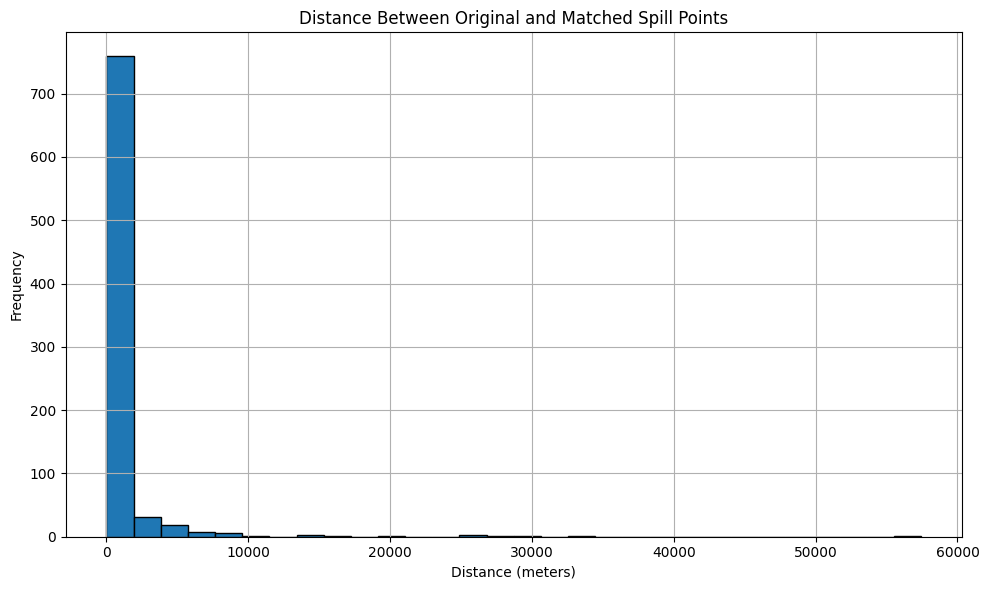

In [6]:
# range of distances
# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(matched_spills_gdf['match_distance_m'].dropna(), bins=30, edgecolor='black')
plt.title('Distance Between Original and Matched Spill Points')
plt.xlabel('Distance (meters)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

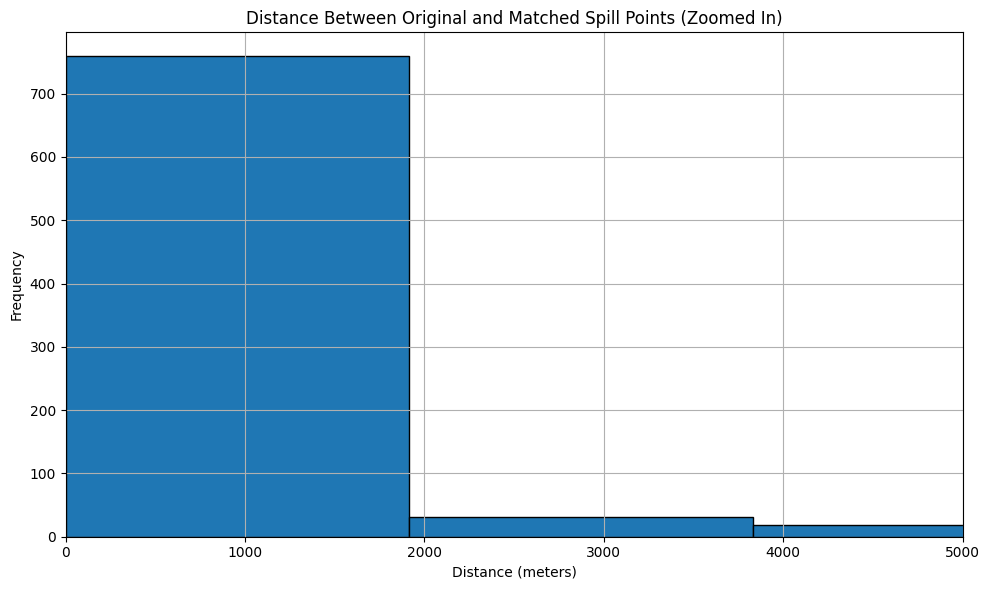

In [7]:
# Plot histogram and zoom in
plt.figure(figsize=(10, 6))
plt.hist(matched_spills_gdf['match_distance_m'].dropna(), bins=30, edgecolor='black')
plt.title('Distance Between Original and Matched Spill Points (Zoomed In)')
plt.xlabel('Distance (meters)')
plt.ylabel('Frequency')
plt.xlim(0, 5000)  # Zoom in on shorter distances
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
print(combined_gdf.shape)

(163137, 46)


In [9]:
combined_gdf.head()

,Operator,Fluid,Material,Diam_in,Status,Length_ft,SHAPE_Length,LOCATION_ID,FLOWLINEID,STARTLOCATIONID,...,spill_Detailed Root Cause Type,spill_Long,spill_Lat,spill_facility_status,spill_Metallic?,spill_incident_date,spill_matched_crudeoil_idx,spill_match_distance_m,geometry,risk
0,GREAT WESTERN OPERATING COMPANY LLC,Oil,Steel,2.0,Active,542.71,165.354619,470449.0,470450.0,NaN,...,Unknown,-104.467746,39.602613,AC,Unknown,2018-01-23 00:00:00,17264.0,26869.639020,"LINESTRING (-104.47065 39.8447, -104.47245 39....",1
1,PDC ENERGY INC,None,None,NaN,Partial Removed see comment,353.54,107.717138,471975.0,471990.0,328254.0,...,Unknown,-104.674320,40.385970,CL,Unknown,2018-02-08 00:00:00,8220.0,361.275164,"LINESTRING (-104.67983 40.3862, -104.67857 40....",1
2,KERR MCGEE OIL & GAS ONSHORE LP,PRODUCED WATER,None,1.0,REMOVED,162.94,49.645825,460727.0,462980.0,305719.0,...,Unknown,-104.631328,40.132392,CL,Unknown,2018-03-09 00:00:00,148076.0,578.344890,"LINESTRING (-104.63096 40.1376, -104.63093 40....",1
3,NOBLE ENERGY INC,Multiphase,Carbon Steel,2.0,Active,2000.31,609.458576,457851.0,457928.0,323679.0,...,Unknown,-104.602541,40.319666,CL,Unknown,2018-03-15 00:00:00,34892.0,10.848928,"LINESTRING (-104.60942 40.32153, -104.60267 40...",1
4,NOBLE ENERGY INC,Multiphase,Carbon Steel,2.0,Active,852.25,259.664035,455178.0,455852.0,310146.0,...,Unknown,-104.754486,40.484583,CL,Unknown,2018-03-22 00:00:00,96759.0,20.107660,"LINESTRING (-104.7565 40.48315, -104.75445 40....",1


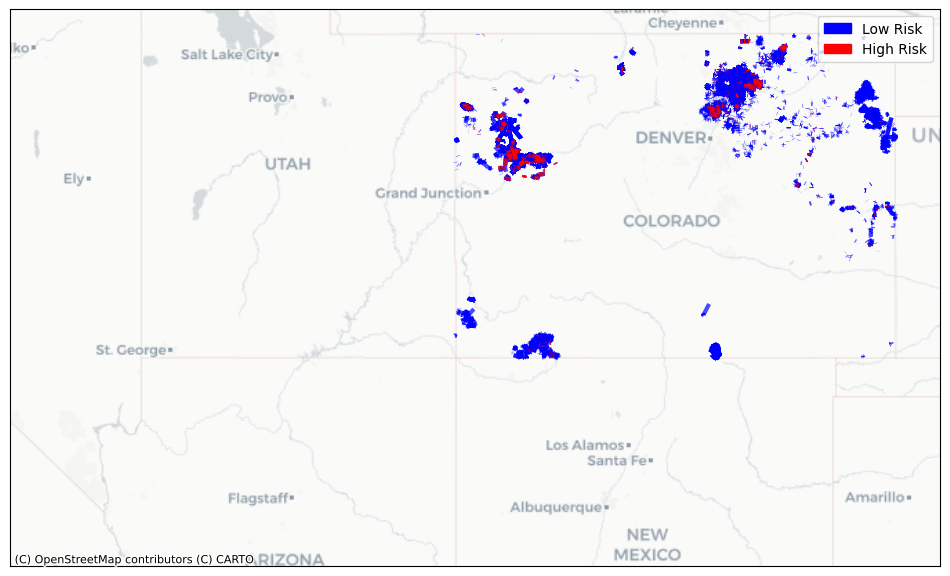

In [10]:
# Convert CRS to EPSG:3857 for contextily base map
combined_gdf_wm = combined_gdf.to_crs(epsg=3857)

# Define custom colors and normalization
cmap = ListedColormap(['blue', 'red'])
norm = Normalize(vmin=0, vmax=1)

# Sort the data by risk level, assuming higher risk has higher numerical value
combined_gdf_wm = combined_gdf_wm.sort_values(by='risk')

# Plotting
fig, ax = plt.subplots(figsize=(12, 12))  # Increased plot size
combined_gdf_wm.plot(column='risk', ax=ax, cmap=cmap, norm=norm, alpha=0.7, linewidth=3)  # Increased line width for better visibility

# Add base map
# ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Create custom legend
low_risk_patch = mpatches.Patch(color='blue', label='Low Risk')
high_risk_patch = mpatches.Patch(color='red', label='High Risk')
plt.legend(handles=[low_risk_patch, high_risk_patch], loc='upper right')

# ax.set_title('Spatial Distribution of Flowline Risk in Colorado')
ax.set_xticks([])  # Remove x ticks for cleaner look
ax.set_yticks([])  # Remove y ticks

plt.show()

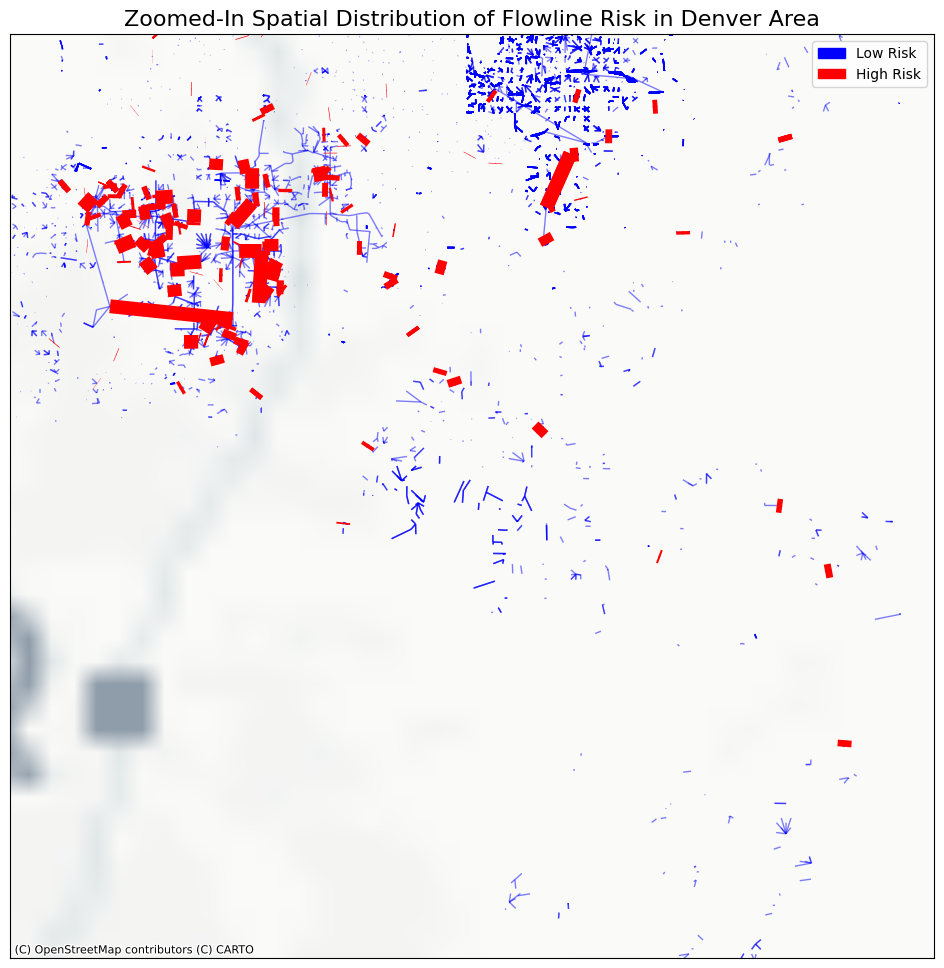

In [11]:
# Separate the data by risk level
low_risk = combined_gdf_wm[combined_gdf_wm['risk'] == 0]
high_risk = combined_gdf_wm[combined_gdf_wm['risk'] == 1]

# Plotting
fig, ax = plt.subplots(figsize=(12, 12))  # Increased plot size

# Plot low-risk geometries (blue) first
low_risk.plot(ax=ax, color='blue', alpha=0.5, linewidth=1)

# Plot high-risk geometries (red) on top with a much larger size
high_risk.plot(ax=ax, color='red', alpha=1.0, linewidth=10)  # Significantly increased line width

# Add a lighter, minimalistic base map to reduce visual clutter
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Create custom legend
low_risk_patch = mpatches.Patch(color='blue', label='Low Risk')
high_risk_patch = mpatches.Patch(color='red', label='High Risk')
plt.legend(handles=[low_risk_patch, high_risk_patch], loc='upper right')

# Set the plot limits to zoom into the desired area
ax.set_xlim([-11700000, -11600000])
ax.set_ylim([4800000, 4900000])

# Clean up axis
ax.set_xticks([])  # Remove x ticks for cleaner look
ax.set_yticks([])  # Remove y ticks

# Optional: Add title
ax.set_title('Zoomed-In Spatial Distribution of Flowline Risk in Denver Area', fontsize=16)

# Display the plot
plt.show()